# PySCNet: A tool for reconstructing and analyzing gene regulatory network from single-cell RNA-Seq data

PySCNet includes four modules:

1) **Pro-precessing**: initialize a gnetData object consisting of Expression Matrix, Cell Attributes, Gene Attributes and Network Attributes; <br/>
2) **BuildNet**: reconstruct GRNs by various methods implemented in docker;<br/>
3) **NetEnrich**: network analysis including consensus network detection, gene module identification and trigger path prediction as well as network fusion;<br/>
4) **Visulization**: network illustration.<br/>

As [scanpy](https://scanpy.readthedocs.io/en/stable/) provides very great toolkits for single cell transcriptomics data analysis. PySCNet can be considered as a downstream analysis tool especially for gene regulatory network analysis. Besides identifying cell population, marker genes detection and cell trajectory analysis, investigating the causal association among genes and transcription factors is also curial for understanding the molecular mechnisms behind.

This tutorial guides you how to build cell specific gene regulatory network applying various tools, predict consensus network and gene module detection as well as dynamic network visualization.

In [1]:
from __future__ import absolute_import
import warnings
warnings.filterwarnings("ignore")

import sys
import os
import itertools
import scanpy as sc

sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, facecolor='white')

from pyvis.network import Network
import pandas as pd
import copy
import numpy as np
from pyscnet.Preprocessing import gnetdata
from pyscnet.BuildNet import gne_dockercaller as gdocker
from pyscnet.NetEnrich import graph_toolkit as gt
from pyscnet.Plotting import show_net as sn
from pyscnet.Plotting import geneHeatmap

scanpy==1.5.1 anndata==0.7.4 umap==0.4.6 numpy==1.17.5 scipy==1.4.1 pandas==1.0.5 scikit-learn==0.22.1 statsmodels==0.10.1 python-igraph==0.8.2 louvain==0.6.1 leidenalg==0.8.1


### Data resource
PBMC data preprocessed and analyzed by scanpy as explained in [this tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html). pyscnet provides an interface which converts processed [AnnData](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html) from scanpy into gnetData.

In [2]:
import _pickle as pk
with open('data/scanpy_obj.pk', 'rb') as input:
    adata = pk.load(input)

### Analysis results from scanpy
As shown below, there are 8 cell types predicted and ranked marker genes illustrated.

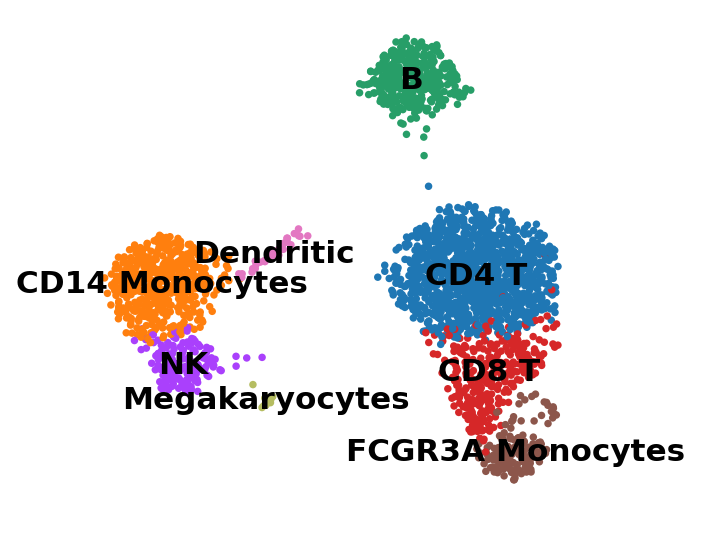

In [3]:
sc.pl.umap(adata, color='leiden', legend_loc='on data', title='', frameon=False)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


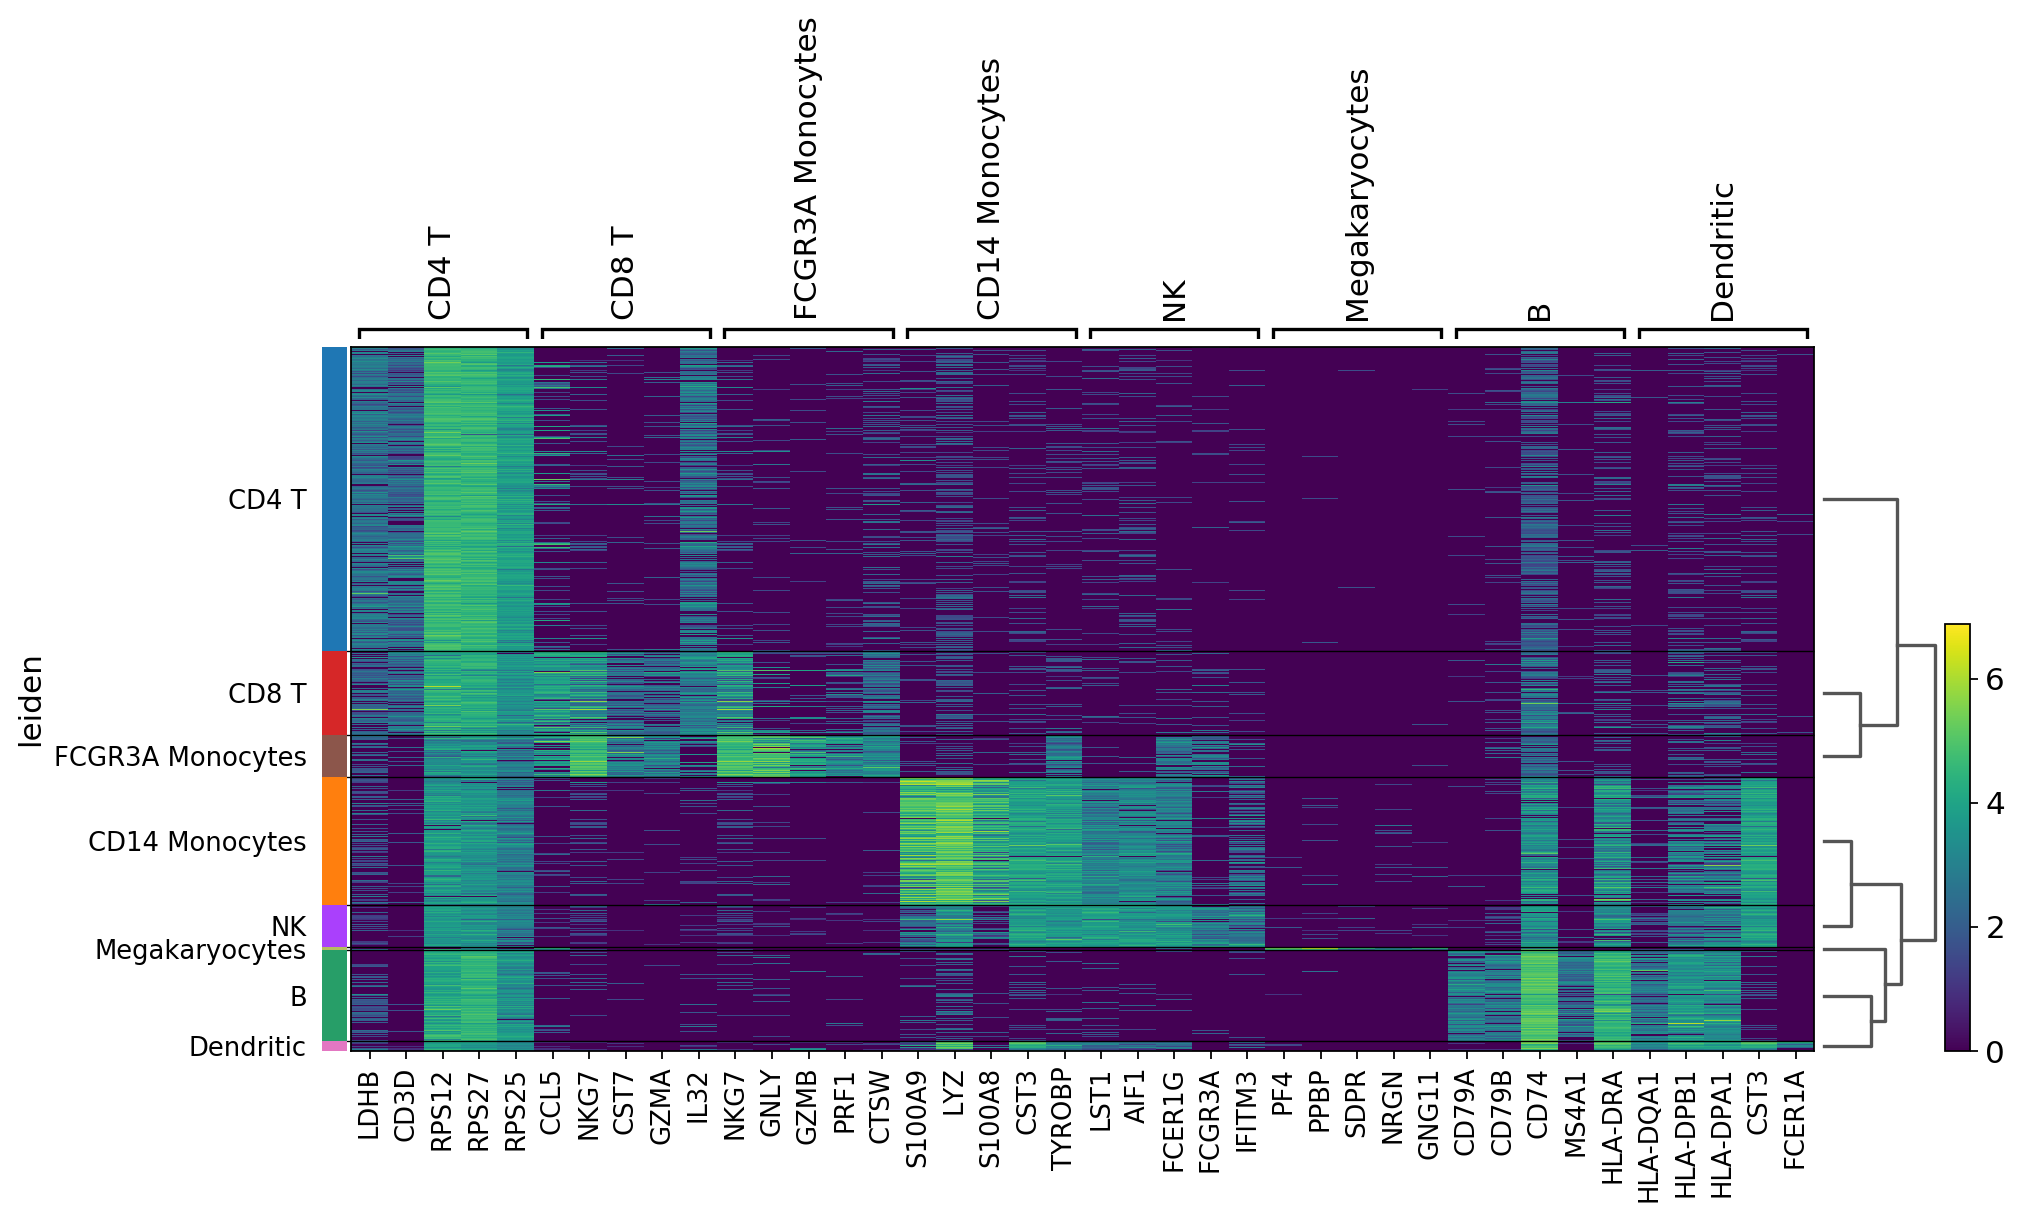

In [4]:
sc.tl.rank_genes_groups(adata, groupby='leiden')
sc.pl.rank_genes_groups_heatmap(adata, n_genes=5)

### Preprocessing: Import scanpy object into pyscnet 
There are two ways of importing scanpy object into pyscnet: 1) import from local pickle file; 2) import from annData

In [5]:
scanpy_gne = gnetdata.load_from_scanpy(filepath='data/scanpy_obj.pk')
scanpy_gne.info

Gnetdata object with 
ExpMatrix: 1838 x 2638
CellAttrs:dict_keys(['CellInfo'])
GeneAttrs:dict_keys(['GeneInfo'])
NetAttrs:dict_keys(['parameters'])


### Feature selection for each cell type
For each cell type, it is very important to pre-select features for creating gene regulatory network as there is less sense of including low expressed genes. To do so, top ranked markers genes of cell sub-population are selected for GRN construction. For instance, signatrues of CD8 t cells are used for CD8 T specific GRN.

In [6]:
Features = list(adata.uns['rank_genes_groups']['names']['CD8 T'])
Features = set(Features) & set(scanpy_gne.ExpMatrix.index)

### BuildNet: Construct GRN by applying popular methods 
As reported in [GRN benchmark paper](https://pubmed.ncbi.nlm.nih.gov/31907445/), although some tools were designed for estimating gene regulatory relationship from transcriptomic data, only three methods ([GENIE3](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0012776), [PIDC](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5624513/) and [GRNBOOST2](https://academic.oup.com/bioinformatics/article-abstract/35/12/2159/5184284?redirectedFrom=fulltext)) were considered as competitive. However, results generated from different algorithms based on different assumptions are inconsistent. Therefore, defining a consensus network from multiple network becomes essential for the downstream analysis.

In [ ]:
scanpy_gne = gdocker.rundocker(scanpy_gne.deepcopy, method='GENIE3', 
                               feature=Features, cell_clusterid='CD8 T',
                                select_by='leiden')

In [ ]:
scanpy_gne = gdocker.rundocker(scanpy_gne.deepcopy, method='PIDC', 
                               feature=Features, cell_clusterid='CD8 T',
                                select_by='leiden')

In [ ]:
scanpy_gne = gdocker.rundocker(scanpy_gne.deepcopy, method='CORR', 
                               feature=Features, cell_clusterid='CD8 T',
                                select_by='leiden')

In [ ]:
scanpy_gne = gdocker.rundocker(scanpy_gne.deepcopy, method='GRNBOOST2', 
                               feature=Features, cell_clusterid='CD8 T',
                                select_by='leiden')

In [9]:
list(filter(lambda x:'links' in x, scanpy_gne.NetAttrs.keys()))

['GENIE3_links', 'PIDC_links', 'CORR_links', 'GRNBOOST2_links']

The GRN result is saved into **NetAttrs** as a dataframe consisting *source*, *target* and *weight*. Top edges ordered by weight can be used for creating gene correlation graph.

### NetEnrich: Consensus edges and Build graph
pyscnet provides multiple ways of predicting consensus network: 

1) random forest classification; <br/>
2) network intersection; <br/>
3) graph embedding based prediction. <br/>

Given consensus prediction, top *k* edges are selected for building gene graph. Genes importance can be estimated via node centralities including **Degree, PageRank, Closeness**. Furthermore, gene modules are predicted by applying community detection algorithms.

In [8]:
#find consensus links based on ensemble classification
scanpy_gne = gt.find_consensus_graph(scanpy_gne, method='ensemble', threshold=2)

#build graph for consensus links
scanpy_gne = gdocker.buildnet(scanpy_gne, key_links='consensus')

there are 34 consensus edges found!
graph added into NetAttrs


In [9]:
scanpy_gne = gt.detect_community(scanpy_gne)

gene communities added into NetAttrs


In [10]:
#For consensus graph, gene importance can be via node centrality
scanpy_gne = gt.get_centrality(scanpy_gne)

#gene module detected by louvain clustering
scanpy_gne = gt.detect_community(scanpy_gne)

node centralities added into NetAttrs.
gene communities added into NetAttrs


### NetEnrich: Graph travel and supervised random walk
NetEnrich module integretes graph traversal techniques to expolre gene regulatory network. It includes **Breadth-first search**, **Depth-first search** and **Supervised random walk**. In this way, gene trigger paths indicating genes with hidden associations can be predicted. 

In [11]:
path = gt.graph_traveral(scanpy_gne.NetAttrs['graph'], start='CCL5', threshold=5, method='bfs')

In [12]:
random_path = gt.random_walk(scanpy_gne, start='CCL5', supervisedby='pageRank', steps=5)
random_path

['CCL5', 'GZMH', 'NKG7', 'GZMB', 'FGFBP2', 'CCL4']

### Plotting: Network Visualization 

In [15]:
sn.dynamic_netShow(scanpy_gne, filename='result/test.html', link_key = 'consensus')

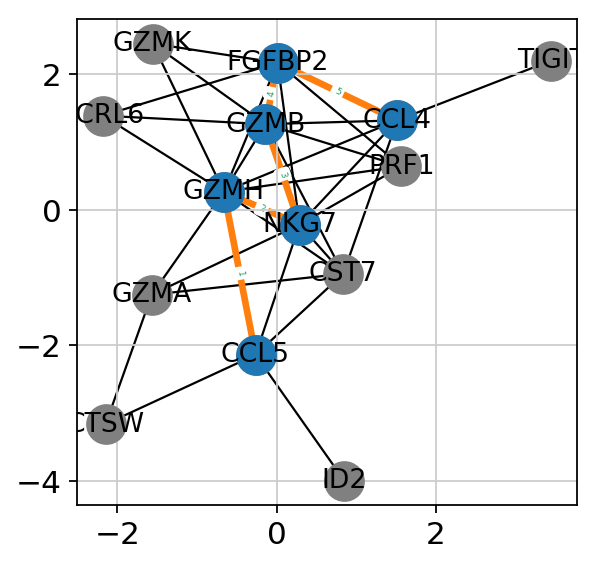

In [13]:
sn.static_netShow(scanpy_gne, filename ='result/test.pdf', link_key = 'consensus', 
                  random_path=random_path, path_highlight=True)


In [7]:
 #save pyscnet as pickle
# scanpy_gne.save_as('data/pyscnet_scanpy.pk')
scanpy_gne = gnetdata.load_Gnetdata_object('data/pyscnet_scanpy.pk')